In [105]:
import numpy as np
#import cv2
from skimage import io
import numpy.ma as ma
import matplotlib.pyplot as plt 

In [2]:
picture = io.imread('../snapshots/frame-13.jpg')

(2880, 2880, 3)


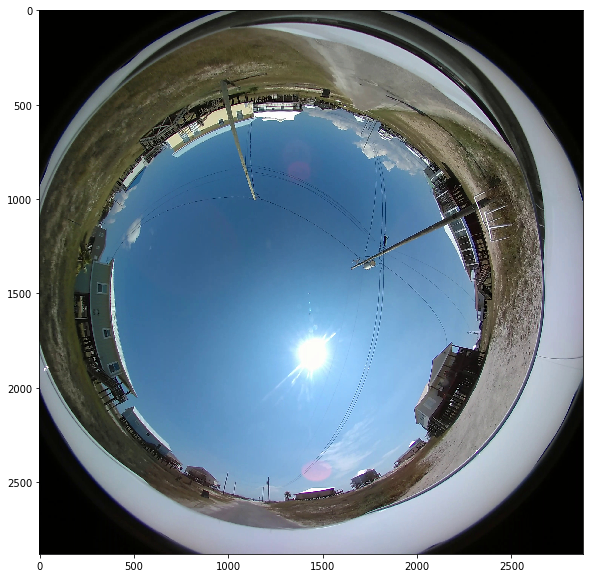

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(picture)
print(picture.shape)
plt.show()

In [27]:
import numpy as np
import numpy.ma as ma
x = np.array([1, 2, 3, -1, 5])

In [29]:
mx = ma.masked_array(x, mask=[0, 0, 0, 1, 0])
mx

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)

In [32]:
mx.sum()

11

In [33]:
y = ma.array([1, 2, 3], mask = [0, 1, 0])

In [6]:
np.zeros((6,6))

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

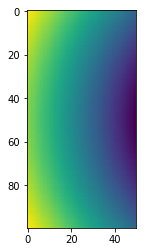

In [204]:
def circular_mask(size=100):
    #mask = np.zeros(size)
    xc, yc = size/2, 100
    return np.array([[np.sqrt((i+.5-xc)**2 + (j+.5-yc)**2) for j in range(int(size/2))] for i in range(size)])

circle = circular_mask()

plt.imshow(circle)
plt.show()

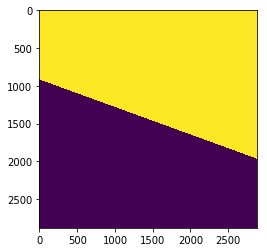

In [258]:
def angle_mask(size=(2880,2880), angle=70):
    theta = angle/180*np.pi
    xc, yc = size[0]/2, size[1]/2
    a = np.tan(theta)
    b = yc-(a*xc)
    
    #print(a, b)
    
    mask = np.zeros(size)
    for i, line in enumerate(mask):
        for j, val in enumerate(line):
            if j+.5 > a * (i+.5) + b:
                mask[i,j]=1
            
        
    return mask
angle = angle_mask()

plt.imshow(angle)
plt.show()

In [220]:
circlemask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [219]:
circlemask = ma.masked_inside(circle, 100, 200).mask
lowmask = angle_mask(angle=45)==0 # will be higher than this value
highmask = angle_mask(angle=90)==1 # will be lower than this value
maskasm = np.stack([circlemask, lowmask, highmask], axis=-1)
finalmask = np.where(np.ones(circlemask.shape), np.all(maskasm, axis=-1),1)

plt.imshow(finalmask)
plt.show()

ValueError: all input arrays must have the same shape

In [218]:
circlemask

False

In [144]:
angle_mask(angle=45)==1

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [158]:
np.stack([circlemask, lowmask], axis=-1).shape

(500, 500, 2)

In [186]:
np.stack([circlemask, lowmask, highmask], axis=-1).shape

(2880, 2880, 3)

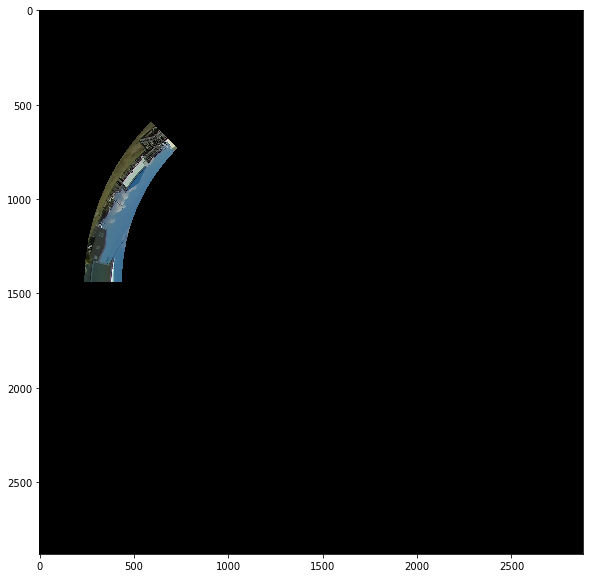

In [196]:
crop = np.stack([finalmask, finalmask, finalmask], axis=-1)*picture
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop)

plt.show()

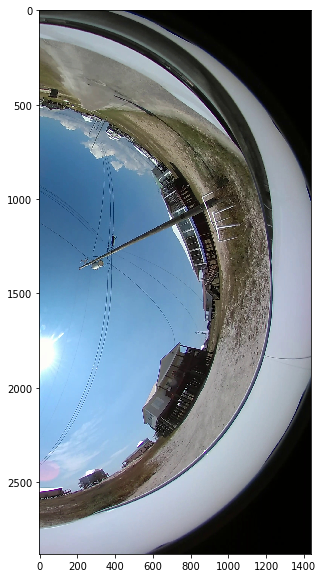

In [238]:

halfpic = picture[:, 1440:,:]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(halfpic)

plt.show()

In [412]:
class Camera():
    def __init__(self, picture,
                        side=1, #0=left, 1=right
                        pixels=10, #final picture resolution
                        pictsize=30, #in degrees
                        ):
        
        self.picture = picture
        self.pixels = pixels
        self.side = side
        self.original_size = self.picture.shape[0]
        self.pictsize = pictsize
        
        self.half = self.get_half()
        self.__update_distances()
    
    def show_half(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(self.half)
        plt.show()
        
    def show_cropped(self, radius=60, theta=45):
        fig, ax = plt.subplots(figsize=(20, 20))
        crop = self.get_cropped(radius=radius, theta=theta)/255
        ax.imshow(crop)
        plt.show()
        
    def get_cropped(self, radius, theta):
        finalmask = self.get_complete_mask(radius=radius, loangle=theta-self.pictsize/2, hiangle=theta+self.pictsize/2)
        #crop = np.stack([finalmask, finalmask, finalmask], axis=-1) * self.half
        empty  = np.zeros(self.half.shape)
        empty.fill(np.nan)
        crop = np.where(np.stack([finalmask, finalmask, finalmask], axis=-1),
                       self.half,
                       empty)
        return crop
    
    def get_half(self):
        if self.side == 0:
            return self.picture[:,:int(self.original_size/2),:]
        else:
            return self.picture[:,int(self.original_size/2):,:]   
    
    def __update_distances(self):
        xc, yc = self.original_size/2, np.abs(self.side-1)*self.original_size/2
        self.distances = np.array([[np.sqrt((i+.5-xc)**2 + (j+.5-yc)**2) for j in range(int(self.original_size/2))] for i in range(self.original_size)])
    
    def get_ring_mask(self, radius):
        #convert angle in pixels
        ratio = 1/90 * (self.original_size/2)
        mindist = (radius-self.pictsize/2) * ratio
        maxdist = (radius+self.pictsize/2) * ratio
        circlemask = ma.masked_inside(self.distances, mindist, maxdist)
        return circlemask.mask
    
    def angle_mask(self, angle, cropside):
        """cropside = 0 --> higher
           cropside = 1 --> lower """
        
        theta = angle/180*np.pi
        xc, yc = self.original_size/2, np.abs(self.side-1)*self.original_size/2
        a = np.tan(theta)
        b = yc-(a*xc)
    
        mask = np.zeros((self.original_size, int(self.original_size/2)))
        for i, line in enumerate(mask):
            for j, val in enumerate(line):
                if j+.5 > a * (i+.5) + b:
                    mask[i,j]=1
        return mask == cropside
    
    def get_complete_mask(self, radius, loangle, hiangle):
        circlemask = self.get_ring_mask(radius=radius)
        lowmask = self.angle_mask(angle = loangle, cropside=1)
        highmask = self.angle_mask(angle = hiangle, cropside=0)
        maskasm = np.stack([circlemask, lowmask, highmask], axis=-1)
        finalmask = np.where(np.ones(circlemask.shape), np.all(maskasm, axis=-1),1)
        return finalmask
    
    def render(self, radius=60, theta=45):
        rendered = np.zeros((self.pixels, self.pixels, 3))
        
        steps = self.pictsize / self.pixels
        
        for i in range(self.pixels):
            for j in range(self.pixels):
                pixelradius = radius-self.pictsize/2 + i*steps   # expressed in degree
                pixeltheta =  radius-self.pictsize/2 + j*steps  # expressed in degree
                cropped = self.get_cropped(radius=pixelradius, theta=pixeltheta)
                for c in range(self.picture.shape[2]):
                    rendered[i,j,c] = np.nanmean(cropped[:,:,c])
        return rendered


    
camera = Camera(picture)
#camera.show_half()
#plt.imshow(camera.get_ring_mask(250))
#camera.get_ring_mask(250)
#camera.show_cropped()
pics = camera.render()

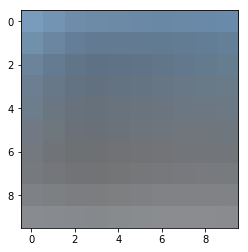

In [415]:
plt.imshow(pics/255)

In [416]:
pics.shape

(10, 10, 3)

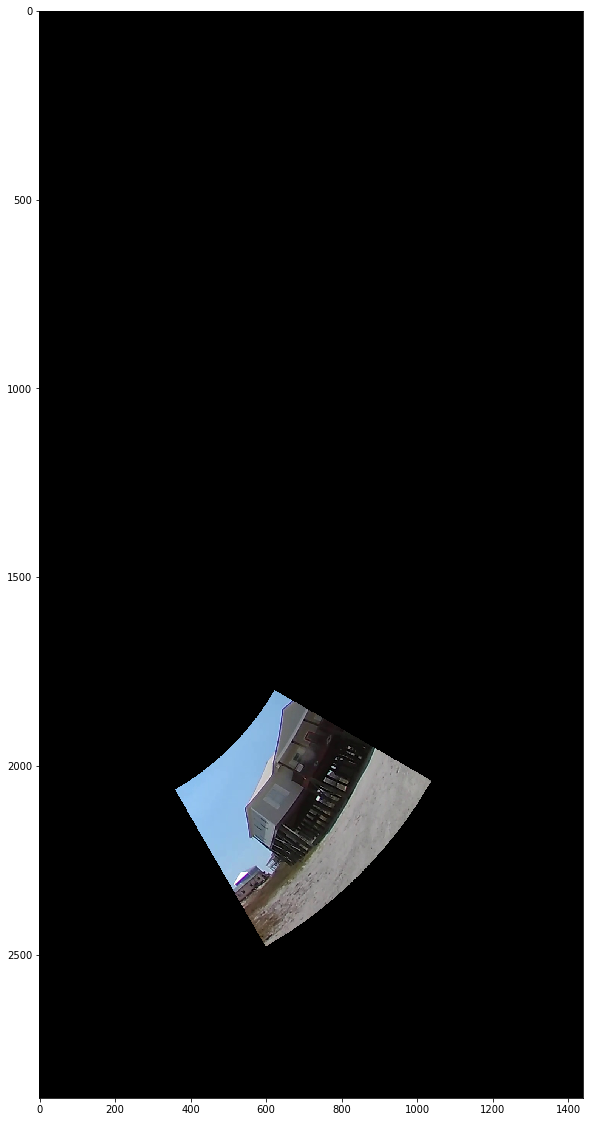

In [398]:
camera.show_cropped(radius=60, theta=45)

In [399]:
zz = camera.get_cropped(radius=60, theta=45)/255
#zz.mean(axis=-1)

In [410]:
zz[:,:,0].shape


(2880, 1440)

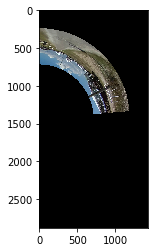

In [397]:
plt.imshow(zz)

In [351]:
ref.mean(axis=1)



array([[0.  , 0.  , 0.  ],
       [0.25, 0.5 , 0.75],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ]])

In [352]:
ref

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 2., 3.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])